In [13]:
import jax.numpy as jnp
import numpy as np
import pyccl as ccl
import pyccl.halos as halos
import matplotlib.pylab as plt

from jax_cosmo.core import Cosmology
import jax_cosmo.power as jcp

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 12

jcp.USE_EMU = True
PATH = "/home/arrykrishna/Desktop/"
SAVEFIG = True

In [2]:
cosmo_jax = Cosmology(
    Omega_c=0.2650,
    Omega_b=0.0492,
    h=0.6724,
    sigma8=0.811,
    n_s=0.9645,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    Neff=3.044,
)

cosmo_ccl = ccl.Cosmology(
    Omega_c=0.2650,
    Omega_b=0.0492,
    h=0.6724,
    sigma8=0.811,
    n_s=0.9645,
    Neff=3.044,
    transfer_function="eisenstein_hu",
    matter_power_spectrum="halofit",
)

## Halo Mass Function

In [3]:
from jax_cosmo.halos.hmbase import compute_sigma, calculate_mass_function
from jax_cosmo.halos.hmfunc import JAXMassFuncBocquet16, JAXMassFuncTinker08

In [4]:
interpolator = compute_sigma(cosmo_jax)

In [72]:
m_arr = jnp.geomspace(1.01e12, 1e15, 128) / cosmo_ccl["h"]
z_grid = jnp.linspace(0, 1, 10)

In [73]:
# JAXMassFuncAngulo12()
# JAXMassFuncBocquet16()
# JAXMassFuncDespali16()
# JAXMassFuncTinker08()
# JAXMassFuncTinker10()
# JAXMassFuncWatson13() -> In CCL: halos.MassFuncWatson13(mass_def=ccl.halos.MassDefFof)
# JAXMassFuncSheth99()
# JAXMassFuncPress74()
# JAXMassFuncJenkins01()

jax_hm_func = JAXMassFuncTinker08()  # JAXMassFuncBocquet16()
ccl_hm_func = halos.MassFuncTinker08()  # halos.MassFuncBocquet16()

record_mf_ccl = []
record_mf_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    mf_ccl = ccl_hm_func(cosmo_ccl, m_arr, a.item())
    mf_jax, _ = calculate_mass_function(cosmo_jax, m_arr, a, jax_hm_func, interpolator)
    record_mf_ccl.append(mf_ccl)
    record_mf_jax.append(mf_jax)

record_mf_ccl = jnp.asarray(record_mf_ccl).T
record_mf_jax = jnp.asarray(record_mf_jax).T

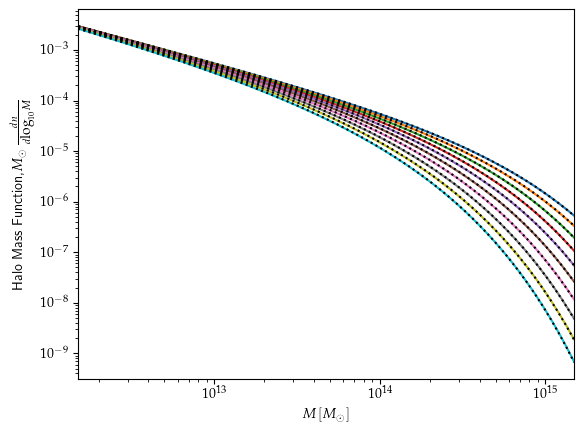

In [76]:
# plt.plot(m_arr, m_arr.reshape(-1, 1) * record_mf_ccl)
# plt.plot(m_arr, m_arr.reshape(-1, 1) * record_mf_jax, linestyle=":", color="k")

plt.plot(m_arr, record_mf_ccl)
plt.plot(m_arr, record_mf_jax, linestyle=":", color="k")

plt.ylabel(r"Halo Mass Function," + r"$M_{\odot}\,\frac{dn}{d\textrm{log}_{10}M}$")
plt.xlabel(r"$M\,[M_{\odot}]$")
plt.xlim(min(m_arr), max(m_arr))
plt.xscale("log")
plt.yscale("log")
if SAVEFIG:
    plt.savefig(f"{PATH}halos_hm.pdf", bbox_inches="tight")
plt.show()

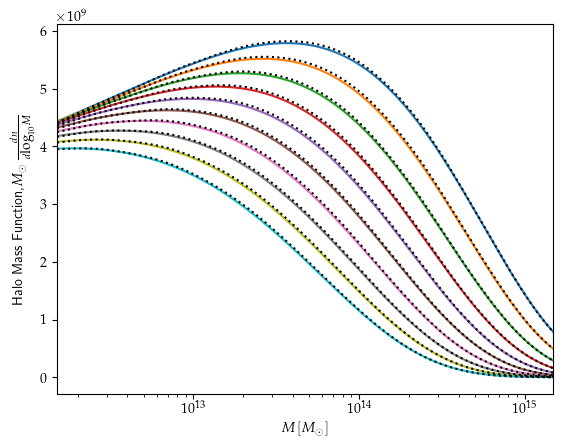

In [78]:
plt.plot(m_arr, m_arr.reshape(-1, 1) * record_mf_ccl)
plt.plot(m_arr, m_arr.reshape(-1, 1) * record_mf_jax, linestyle=":", color="k")

plt.ylabel(r"Halo Mass Function," + r"$M_{\odot}\,\frac{dn}{d\textrm{log}_{10}M}$")
plt.xlabel(r"$M\,[M_{\odot}]$")
plt.xlim(min(m_arr), max(m_arr))
plt.xscale("log")
if SAVEFIG:
    plt.savefig(f"{PATH}halos_hm.pdf", bbox_inches="tight")
plt.show()

## Halo Bias

In [15]:
from jax_cosmo.halos.hmbase import get_logM_sigM
from jax_cosmo.halos.hmbias import HaloBiasBhattacharya11

In [16]:
ccl_halo_bias = halos.HaloBiasBhattacharya11()
jax_halo_bias = HaloBiasBhattacharya11()

record_bias_ccl = []
record_bias_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    bias_ccl = ccl_halo_bias(cosmo_ccl, m_arr, a.item())

    # we need to compute \sigma_M for a given mass
    log_mass, sigma_mass, dlns_dlogM = get_logM_sigM(
        cosmo_jax, m_arr, a.item(), interpolator
    )
    bias_jax = jax_halo_bias.compute_bias(cosmo_jax, sigma_mass, a.item())

    record_bias_ccl.append(bias_ccl)
    record_bias_jax.append(bias_jax)

In [17]:
record_bias_ccl = jnp.asarray(record_bias_ccl)
record_bias_jax = jnp.asarray(record_bias_jax)

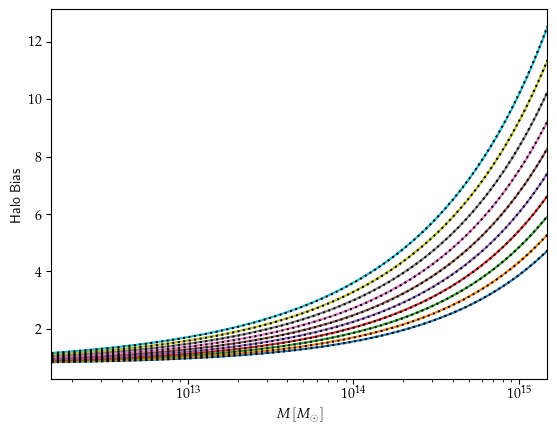

In [ ]:
plt.plot(m_arr, record_bias_ccl.T)
plt.plot(m_arr, record_bias_jax.T, c="k", linestyle=":")
plt.ylabel(r"Halo Bias")
plt.xlabel(r"$M\,[M_{\odot}]$")
plt.xlim(min(m_arr), max(m_arr))
plt.xscale("log")
if SAVEFIG:
    plt.savefig(f"{PATH}halo_bias.pdf", bbox_inches="tight")
plt.show()

## Concentration

In [19]:
from pyccl.halos.concentration import ConcentrationDuffy08
from jax_cosmo.halos.concentration import JAXConDuffy08

In [20]:
record_conc_ccl = []
record_conc_jax = []

conc_ccl = ConcentrationDuffy08()
conc_jax = JAXConDuffy08()

for z in z_grid:
    a = 1.0 / (1.0 + z)
    concenctration_ccl = conc_ccl(cosmo_ccl, m_arr, a.item())
    concenctration_jax = conc_jax.compute_concentration(
        cosmo_jax, m_arr, a.item(), interpolator
    )

    record_conc_ccl.append(concenctration_ccl)
    record_conc_jax.append(concenctration_jax)

In [21]:
record_conc_ccl = jnp.asarray(record_conc_ccl)
record_conc_jax = jnp.asarray(record_conc_jax)

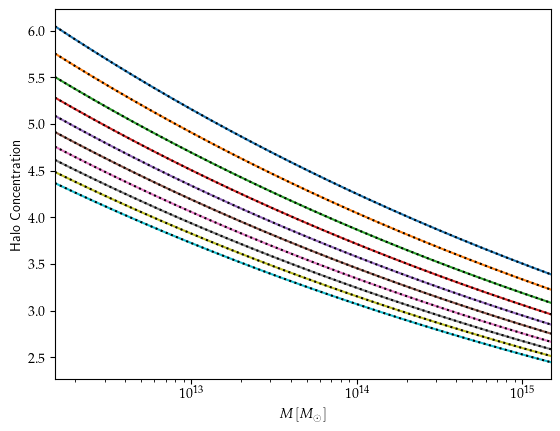

In [ ]:
plt.figure()
plt.plot(m_arr, record_conc_ccl.T)
plt.plot(m_arr, record_conc_jax.T, c="k", linestyle=":")
plt.ylabel(r"Halo Concentration")
plt.xlabel(r"$M\,[M_{\odot}]$")
plt.xlim(min(m_arr), max(m_arr))
plt.xscale("log")
if SAVEFIG:
    plt.savefig(f"{PATH}halo_concentration.pdf", bbox_inches="tight")
plt.show()

## Sine and Cosine Integral

In [23]:
from scipy.special import sici
from jax_cosmo.scipy.special import compute_sici

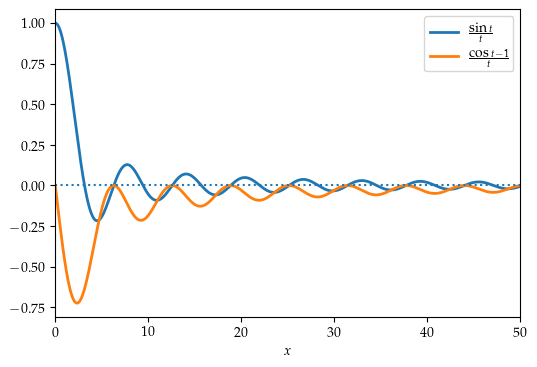

In [ ]:
xmax = 50
domain = jnp.linspace(1e-5, xmax, 1000)
f_sin = jnp.sin(domain) / domain
f_cos = (jnp.cos(domain) - 1.0) / domain

plt.figure(figsize=(6, 4))
plt.plot(domain, f_sin, lw=2, label=r"$\frac{\textrm{sin}\,t}{t}$")
plt.plot(domain, f_cos, lw=2, label=r"$\frac{\textrm{cos}\,t-1}{t}$")
plt.axhline(0.0, linestyle=":")
plt.xlabel(r"$x$")
plt.xlim(0, xmax)
plt.legend()
if SAVEFIG:
    plt.savefig(f"{PATH}sine_cosine.pdf", bbox_inches="tight")
plt.show()

In [25]:
testpoints = np.linspace(1e-3, 100, 1000)
scipy_si, scipy_ci = sici(testpoints)
jc_si, jc_ci = compute_sici(testpoints)

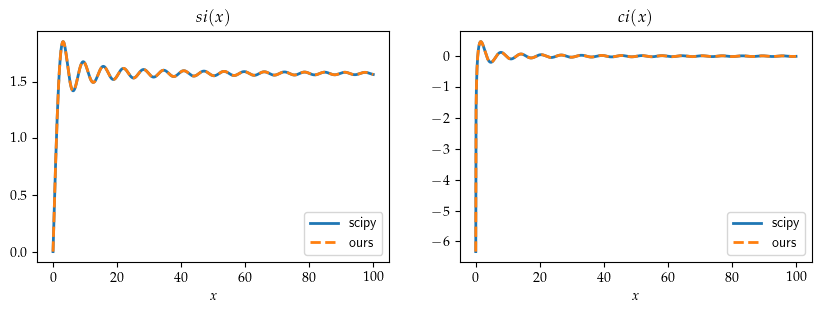

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.title(r"$si(x)$")
plt.plot(testpoints, scipy_si, lw=2, label="scipy")
plt.plot(testpoints, jc_si, lw=2, linestyle="--", label="ours")
plt.xlabel(r"$x$")
plt.legend()
plt.subplot(122)
plt.title(r"$ci(x)$")
plt.plot(testpoints, scipy_ci, lw=2, label="scipy")
plt.plot(testpoints, jc_ci, lw=2, linestyle="--", label="ours")
plt.xlabel(r"$x$")
plt.legend()
if SAVEFIG:
    plt.savefig(f"{PATH}sine_cosine_test.pdf", bbox_inches="tight")
plt.show()

## Halo Profile

In [27]:
from jax_cosmo.halos.profiles.nfw import JAXHaloProfileNFW
from jax_cosmo.halos.profiles.hernquist import JAXHaloProfileHernquist
from jax_cosmo.halos.profiles.einasto import JAXHaloProfileEinasto
from jax_cosmo.halos.hmbase import MassDefinition
from jax_cosmo.halos.concentration import JAXConDuffy08

In [28]:
# Radius, wavenumber and mass
r_arr = np.geomspace(1e-2, 1e2, 256)
k_arr = np.geomspace(1e-2, 1e2, 256)
m_arr = np.geomspace(1e11, 1e15, 32)

# We will calculate everything at z=1 (scale factor = 0.5)
a_sf = 0.5

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)

hmd_200c_jax = MassDefinition(200, "critical")
conc_jax = JAXConDuffy08()

### Real Profile

In [29]:
ccl_nfw = ccl.halos.HaloProfileNFW(mass_def=hmd_200c, concentration=cM, truncated=False)
ccl_hq = ccl.halos.HaloProfileHernquist(
    mass_def=hmd_200c, concentration=cM, truncated=False
)
ccl_en = ccl.halos.HaloProfileEinasto(
    mass_def=hmd_200c, concentration=cM, truncated=False
)

ccl_nfw_real = ccl_nfw.real(cosmo_ccl, r_arr, 1e14, a_sf)
ccl_hq_real = ccl_hq.real(cosmo_ccl, r_arr, 1e14, a_sf)
ccl_en_real = ccl_en.real(cosmo_ccl, r_arr, 1e14, a_sf)

In [30]:
jax_nfw = JAXHaloProfileNFW(hmd_200c_jax, conc_jax, truncated=False)
jax_hq = JAXHaloProfileHernquist(hmd_200c_jax, conc_jax, truncated=False)
jax_en = JAXHaloProfileEinasto(hmd_200c_jax, conc_jax, truncated=False)

jax_nfw_real = jax_nfw._real(cosmo_jax, r_arr, 1e14, a_sf, interpolator)
jax_hq_real = jax_hq._real(cosmo_jax, r_arr, 1e14, a_sf, interpolator)
jax_en_real = jax_en._real(cosmo_jax, r_arr, 1e14, a_sf, interpolator)

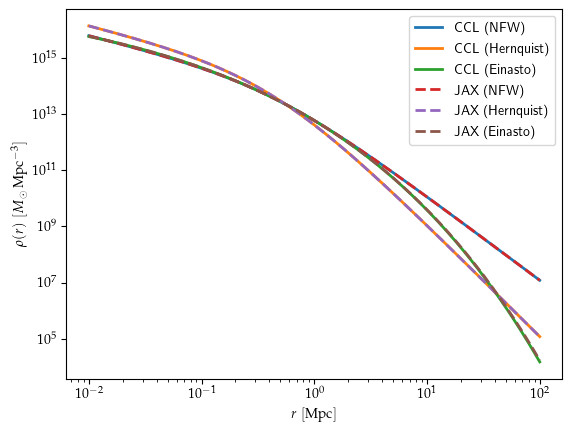

In [ ]:
plt.loglog(r_arr, ccl_nfw_real, lw=2, label="CCL (NFW)")
plt.loglog(r_arr, ccl_hq_real, lw=2, label="CCL (Hernquist)")
plt.loglog(r_arr, ccl_en_real, lw=2, label="CCL (Einasto)")

plt.loglog(r_arr, jax_nfw_real, linestyle="--", lw=2, label="JAX (NFW)")
plt.loglog(r_arr, jax_hq_real, linestyle="--", lw=2, label="JAX (Hernquist)")
plt.loglog(r_arr, jax_en_real, linestyle="--", lw=2, label="JAX (Einasto)")

plt.ylabel(r"$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$")
plt.xlabel(r"$r\,\,[{\rm Mpc}]$")
plt.legend()
if SAVEFIG:
    plt.savefig(f"{PATH}profile_real.pdf", bbox_inches="tight")
plt.show()

### Fourier Profile

In [32]:
ccl_nfw_fourier = ccl_nfw.fourier(cosmo_ccl, k_arr, 1e14, a_sf)
jax_nfw_fourier = jax_nfw._fourier_analytic(cosmo_jax, k_arr, 1e14, a_sf, interpolator)

ccl_hq_fourier = ccl_hq.fourier(cosmo_ccl, k_arr, 1e14, a_sf)
jax_hq_fourier = jax_hq._fourier_analytic(cosmo_jax, k_arr, 1e14, a_sf, interpolator)

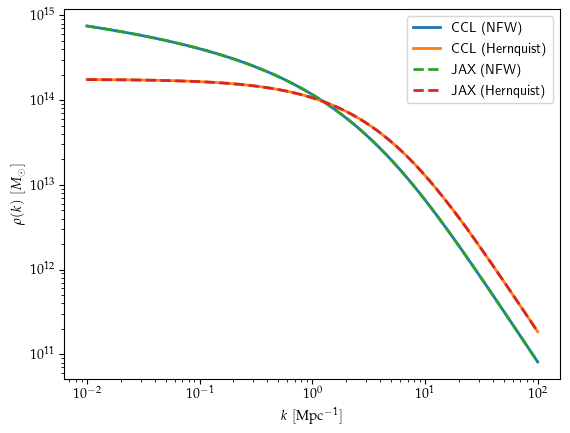

In [ ]:
plt.loglog(k_arr, ccl_nfw_fourier, lw=2, label="CCL (NFW)")
plt.loglog(k_arr, ccl_hq_fourier, lw=2, label="CCL (Hernquist)")

plt.loglog(k_arr, jax_nfw_fourier, linestyle="--", lw=2, label="JAX (NFW)")
plt.loglog(k_arr, jax_hq_fourier, linestyle="--", lw=2, label="JAX (Hernquist)")

plt.ylabel(r"$\rho(k)\,\,[M_\odot]$")
plt.xlabel(r"$k\,\,[{\rm Mpc}^{-1}]$")
plt.legend()
if SAVEFIG:
    plt.savefig(f"{PATH}profile_fourier.pdf", bbox_inches="tight")
plt.show()

### Projected Profiles

In [34]:
ccl_nfw_projected = ccl_nfw.projected(cosmo_ccl, r_arr, 1e14, a_sf)
ccl_hq_projected = ccl_hq.projected(cosmo_ccl, r_arr, 1e14, a_sf)
ccl_en_proj_quad = ccl_en._projected_quad(cosmo_ccl, r_arr, 1e14, a_sf)

jax_nfw_projected = jax_nfw._projected_analytic(
    cosmo_jax, r_arr, 1e14, a_sf, interpolator
)
jax_hq_projected = jax_hq._projected_analytic(
    cosmo_jax, r_arr, 1e14, a_sf, interpolator
)
jax_en_proj_quad = jax_en._projected_quad(cosmo_jax, r_arr, 1e14, a_sf, interpolator)

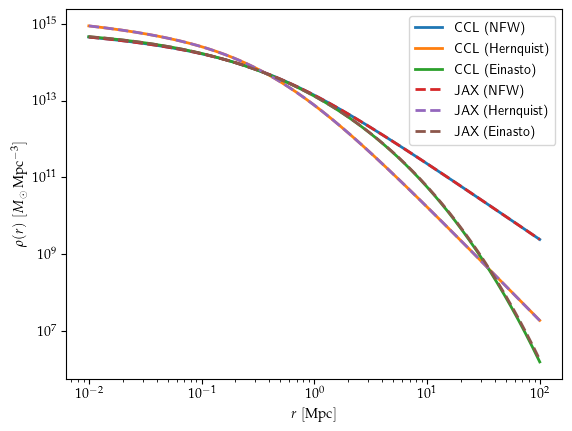

In [ ]:
plt.loglog(r_arr, ccl_nfw_projected, lw=2, label="CCL (NFW)")
plt.loglog(r_arr, ccl_hq_projected, lw=2, label="CCL (Hernquist)")
plt.loglog(r_arr, ccl_en_proj_quad, lw=2, label="CCL (Einasto)")
plt.loglog(r_arr, jax_nfw_projected, linestyle="--", lw=2, label="JAX (NFW)")
plt.loglog(r_arr, jax_hq_projected, linestyle="--", lw=2, label="JAX (Hernquist)")
plt.loglog(r_arr, jax_en_proj_quad, linestyle="--", lw=2, label="JAX (Einasto)")
plt.ylabel(r"$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$")
plt.xlabel(r"$r\,\,[{\rm Mpc}]$")
plt.legend()
if SAVEFIG:
    plt.savefig(f"{PATH}profile_projected.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum

In [ ]:

from pyccl.halos.pk_2pt import halomod_power_spectrum as ccl_halomod_power_spectrum

# from JAX_COSMO
from jax_cosmo.halos.hmbias import HaloBiasTinker10
from jax_cosmo.halos.hmfunc import JAXMassFuncTinker08
from jax_cosmo.halos.hmbase import MassDefinition
from jax_cosmo.halos.profiles.nfw import JAXHaloProfileNFW
from jax_cosmo.halos.concentration import JAXConDuffy08
from jax_cosmo.halos.hm import JAXHMCalculator, halomod_power_spectrum

In [6]:
# Wavenumbers and scale factors
k_arr = jnp.geomspace(1e-4, 1e1, 256)
a_arr = jnp.linspace(0.1, 1, 32)

mass_function = JAXMassFuncTinker08(200, "matter")
halo_bias = HaloBiasTinker10(200, "matter")
mass_definition = MassDefinition(200, "matter")
conc_jax = JAXConDuffy08(mass_def="200m")
halo_profile = JAXHaloProfileNFW(mass_definition, conc_jax, truncated=False)
hmc = JAXHMCalculator(mass_function, halo_bias, mass_definition)

In [8]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM, truncated=False)

In [9]:
hmc_ccl = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=hmd_200m)

In [ ]:
pk_ccl = ccl_halomod_power_spectrum(cosmo_ccl, hmc_ccl, k_arr, 1.0, pM)
pk_jax = halomod_power_spectrum(cosmo_jax, hmc, k_arr, 1.0, interpolator, halo_profile)

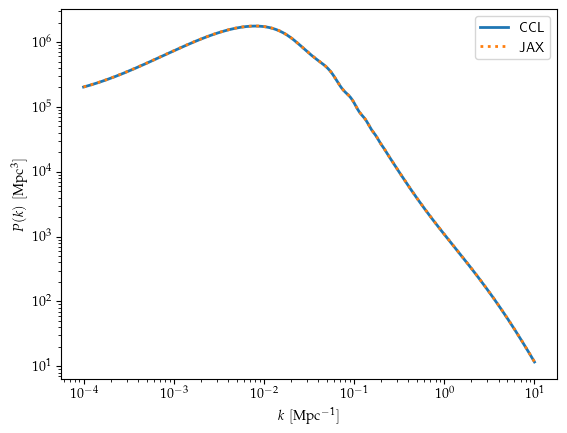

In [14]:
plt.loglog(k_arr, pk_ccl, lw=2, label="CCL")
plt.loglog(k_arr, pk_jax, lw=2, linestyle=":", label="JAX")
plt.legend()
plt.xlabel(r"$k\,\,[{\rm Mpc}^{-1}]$")
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$')
plt.legend()
if SAVEFIG:
    plt.savefig(f"{PATH}power_spectrum.pdf", bbox_inches="tight")
plt.show()